# Data Preprocessing, Feature Engineering, and Visualization for GitHub Repository Survival Analysis

## Introduction
In this notebook, we will preprocess the data, engineer relevant features, and visualize the survival time of GitHub repositories based on their programming language. This is a precursor to applying the Cox Proportional Hazards model for survival analysis.

## Objectives
By the end of this notebook, you will be able to:
* Load and inspect the GitHub repository dataset.
* Handle missing values and clean the data.
* Engineer features necessary for survival analysis.
* Visualize the distribution of survival times.
* Compare the survival times of repositories across different programming languages.

## Data Description
We will use a dataset that contains information about various GitHub repositories. The dataset has the following columns:
- `name`: Name of the repository.
- `full_name`: Full name of the repository.
- `description`: Description of the repository.
- `search_key`: Search key used to find the repository.
- `language`: Programming language used in the repository.
- `key_words`: Keywords associated with the repository.
- `stars`: Number of stars the repository has received.
- `forks`: Number of times the repository has been forked.
- `watchers`: Number of watchers of the repository.
- `open_issues`: Number of open issues in the repository.
- `created_at`: Date and time when the repository was created.
- `updated_at`: Date and time when the repository was last updated.
- `pushed_at`: Date and time when the repository was last pushed.
- `releases`: Number of releases of the repository.

We will focus on analyzing the survival time, calculated as the duration from the repository's creation date to its last update date.

## Prerequisites
To follow this notebook, you should have a basic understanding of Python programming and familiarity with data analysis libraries such as Pandas, NumPy, and Matplotlib. Additionally, you should have Plotly and Lifelines libraries installed for visualization and survival analysis.

## Notebook Outline
1. **Install Required Libraries**: Ensure all necessary libraries are installed.
2. **Load and Inspect Data**: Load the dataset into a Pandas DataFrame and inspect its structure.
3. **Data Preprocessing**: Handle missing values and clean the data.
4. **Feature Engineering**: Create necessary features for survival analysis.
5. **Visualizations**: Generate visualizations to understand the data distribution and survival times.

---


# Import libraries

In [ ]:
%%capture
!pip install lifelines
!pip install plotly

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
import pytz

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
from lifelines.statistics import logrank_test

# Data Loading

In [ ]:
# Load the data
"""
loadin data from github and handling errors with try-except blocks

"""
import os
data_path = os.getenv('DATA_PATH', '/content/languages_frameworks_sample.csv')

try:
    data = pd.read_csv(data_path)
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    raise
except pd.errors.EmptyDataError:
    print("Error: The file is empty. Please check the file content.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

In [ ]:
data

,name,full_name,description,search_key,language,key_words,stars,forks,watchers,open_issues,created_at,updated_at,pushed_at,releases
0,system-design-primer,donnemartin/system-design-primer,Learn how to design large-scale systems. Prep ...,Python,Python,"['design', 'design-patterns', 'design-system',...",264072,44767,264072,435,2017-02-26T16:15:28Z,2024-07-12T16:47:58Z,2024-06-29T00:09:30Z,0
1,awesome-python,vinta/awesome-python,An opinionated list of awesome Python framewor...,Python,Python,"['awesome', 'collections', 'python', 'python-f...",212323,24654,212323,416,2014-06-27T21:00:06Z,2024-07-12T16:45:14Z,2024-07-08T23:26:43Z,0
2,tensorflow,tensorflow/tensorflow,An Open Source Machine Learning Framework for ...,Python,C++,"['deep-learning', 'deep-neural-networks', 'dis...",184034,74063,184034,3727,2015-11-07T01:19:20Z,2024-07-12T16:44:43Z,2024-07-12T16:47:04Z,30
3,Python,TheAlgorithms/Python,All Algorithms implemented in Python,Python,Python,"['algorithm', 'algorithm-competitions', 'algor...",182120,44004,182120,229,2016-07-16T09:44:01Z,2024-07-12T16:26:11Z,2024-07-12T16:25:12Z,0
4,project-based-learning,practical-tutorials/project-based-learning,Curated list of project-based tutorials,Python,NaN,"['beginner-project', 'cpp', 'golang', 'javascr...",181910,23897,181910,148,2017-04-12T05:07:46Z,2024-07-12T16:38:09Z,2024-07-10T18:02:06Z,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10000,bpmn-js-example-model-extension,bpmn-io/bpmn-js-example-model-extension,An example of creating a model extension for b...,Ext-JS,JavaScript,['bpmn-js'],27,14,27,0,2019-03-27T08:47:30Z,2024-03-12T12:57:10Z,2019-04-08T10:57:11Z,0
10001,OS.js-extras,os-js/OS.js-extras,OS.js (v2) - Extra Packages,Ext-JS,JavaScript,[],26,20,26,1,2013-12-02T21:56:08Z,2024-01-25T18:35:17Z,2017-12-15T18:38:00Z,0
10002,jsonschema-extractor,toumorokoshi/jsonschema-extractor,Extract jsonschema from various Python objects,Ext-JS,Python,[],26,9,26,2,2017-06-20T03:32:28Z,2024-02-23T12:47:24Z,2022-10-25T05:09:49Z,0
10003,extractor-js,rsdoiel/extractor-js,Since I originally wrote this a module called ...,Ext-JS,HTML,[],26,4,26,0,2011-08-15T18:08:30Z,2023-01-28T13:26:17Z,2015-11-16T20:02:44Z,0


# Data Preprocessing

Handling missing values

In [ ]:
# check count of null values in each column.
missing_values = data.isna().sum()
missing_values

name             0
full_name        0
description    178
search_key       0
language       627
key_words        0
stars            0
forks            0
watchers         0
open_issues      0
created_at       0
updated_at       0
pushed_at        4
releases         0
dtype: int64

`description` is not needed for this model so we will leave it as it is.

`language` is important key column so we will fill null values by search key.

In [ ]:
# Fill null values in the 'language' column with values from the 'search_key' column
data['language'] = data['language'].fillna(data['search_key'])
data['language'].isna().sum()

0

In [ ]:
language_counts = data['language'].value_counts()
print(language_counts)

language
Python          1286
JavaScript      1177
Java             887
PHP              713
TypeScript       669
                ... 
ActionScript       1
EJS                1
PostScript         1
SMT                1
D                  1
Name: count, Length: 206, dtype: int64


In [ ]:
# Count the number of languages with fewer than 100 repositories
language_counts = data['language'].value_counts()
languages_less_than_100 = language_counts[language_counts <= 10]

# Print the result
print(f"Number of languages with fewer than 100 repositories: {len(languages_less_than_100)}")


Number of languages with fewer than 100 repositories: 142


In [ ]:
languages_frameworks_systems_sample = [
    "Python", "JavaScript", "Java", "C#", "C++", "TypeScript",
    "PHP", "Swift", "Kotlin", "R", "Go", "Rust", "SQL", "Ruby",
    "MATLAB", "Dart", "Scala", "Julia", "Perl", "Objective-C",
    "Shell", "PowerShell", "Elixir", "Haskell", "Lua",
    "FORTRAN", "COBOL", "Pascal", "BASIC", "Lisp", "Ada", "Prolog",
    "Smalltalk", "Assembly Language", "C", "Perl", "ALGOL", "PL/I",
    "Modula-2", "CLIPPER", "FoxPro", "HyperTalk", "dBASE", "SNOBOL",
    "Forth", "Simula", "MUMPS", "RPG", "APL", "Logo",
    "React", "Angular", "Vuejs", "Django", "Flask", "Spring Boot",
    "Laravel", "Ruby-on-Rails", "ASP-NET", "Express-js", "TensorFlow",
    "PyTorch", "FastAPI", "Bootstrap", "jQuery", "Next-js", "Nuxtjs",
    "Svelte", "Symfony", "CakePHP", "Meteor", "Keras", "Hugging-Face-Transformers",
    "Pandas", "Scikit-learn", "Spark",
    "Struts", "GWT", "ColdFusion", "Flex", "TurboGears",
    "Catalyst", "Zope", "Tapestry", "Seaside", "CakePHP",
    "Symfony", "CodeIgniter", "Silverlight", "VB6", "JSP",
    "ASP", "JSF", "Rails", "Swing", "AWT",
    "CORBA", "MFC", "Wicket", "Dojo Toolkit",
    "Prototype-JavaScript-Framework", "Ext-JS"
]

# Get unique languages in the data
unique_languages = data['language'].unique()

# Find languages not in the sample list
missing_languages = [lang for lang in unique_languages if lang not in languages_frameworks_systems_sample]

# Print the count of missing languages
print(f"Number of languages not in the sample list: {len(missing_languages)}")
print("Missing languages:", missing_languages)

Number of languages not in the sample list: 107
Missing languages: ['HTML', 'CSS', 'Jupyter Notebook', 'Roff', 'Makefile', 'Batchfile', 'Dockerfile', 'Zig', 'Vue', 'MDX', 'Groovy', 'OCaml', 'Vim Script', 'Clojure', 'V', 'TeX', 'WebAssembly', 'Hack', 'Assembly', 'Markdown', 'Handlebars', 'Matlab', 'Cuda', 'Emacs Lisp', 'F#', 'Stata', 'Vim script', 'VimL', 'Rich Text Format', 'Awk', 'Visual Basic .NET', 'TSQL', 'Open Policy Agent', 'Erlang', 'Frege', 'Racket', 'Nix', 'MoonScript', 'Fortran', 'Earthly', 'CMake', 'ANTLR', 'REXX', 'Inno Setup', 'Verilog', 'Common Lisp', 'Fennel', 'Scheme', 'Arc', 'wisp', 'Nim', 'SMT', 'SCSS', 'Shen', 'NewLisp', 'Fancy', 'Elm', 'StringTemplate', 'Raku', 'Agda', 'DTrace', 'Macaulay2', 'GDScript', 'VHDL', 'D', 'xBase', 'M4', 'PLpgSQL', '4D', 'Tcl', 'Just', 'GLSL', 'Brainfuck', 'Objective-C++', 'Processing', 'M', 'Genshi', 'ObjectScript', "Ren'Py", 'Mustache', 'BQN', 'Standard ML', 'SVG', 'Logos', 'PostScript', 'Less', 'Blade', 'Astro', 'Pug', 'CoffeeScript', '

In [ ]:
# Update language in data if it's not in the sample list
data.loc[~data['language'].isin(languages_frameworks_systems_sample), 'language'] = data['search_key']

In [ ]:
language_counts = data['language'].value_counts()
print(language_counts)

language
Python         1297
JavaScript     1182
Java            892
PHP             717
TypeScript      673
               ... 
CodeIgniter       7
MFC               6
Zope              6
Next-js           6
GWT               5
Name: count, Length: 99, dtype: int64


`pushed_at` is important so filling with the last update date can be a reasonable approximation.

In [ ]:
# fill nulls of 'pushed_at' column with 'updated_at'
data['pushed_at'] = data['pushed_at'].fillna(data['updated_at'])
data['pushed_at'].isna().sum()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         10005 non-null  object
 1   full_name    10005 non-null  object
 2   description  9827 non-null   object
 3   search_key   10005 non-null  object
 4   language     10005 non-null  object
 5   key_words    10005 non-null  object
 6   stars        10005 non-null  int64 
 7   forks        10005 non-null  int64 
 8   watchers     10005 non-null  int64 
 9   open_issues  10005 non-null  int64 
 10  created_at   10005 non-null  object
 11  updated_at   10005 non-null  object
 12  pushed_at    10005 non-null  object
 13  releases     10005 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 1.1+ MB


In [ ]:
# Convert date columns to datetime
data['created_at'] = pd.to_datetime(data['created_at'])
data['updated_at'] = pd.to_datetime(data['updated_at'])
data['pushed_at'] = pd.to_datetime(data['pushed_at'])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005 entries, 0 to 10004
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   name         10005 non-null  object             
 1   full_name    10005 non-null  object             
 2   description  9827 non-null   object             
 3   search_key   10005 non-null  object             
 4   language     10005 non-null  object             
 5   key_words    10005 non-null  object             
 6   stars        10005 non-null  int64              
 7   forks        10005 non-null  int64              
 8   watchers     10005 non-null  int64              
 9   open_issues  10005 non-null  int64              
 10  created_at   10005 non-null  datetime64[ns, UTC]
 11  updated_at   10005 non-null  datetime64[ns, UTC]
 12  pushed_at    10005 non-null  datetime64[ns, UTC]
 13  releases     10005 non-null  int64              
dtypes: datetime64[ns, UTC]

In [ ]:
# Check for future dates (which is considered invalid)

# Get the current datetime in UTC
now = datetime.now(pytz.UTC)

# Filter for rows with future dates
future_dates = data[(data['created_at'] > now) | (data['updated_at'] > now) | (data['pushed_at'] > now)]
print("Rows with future dates:\n", future_dates)

Rows with future dates:
 Empty DataFrame
Columns: [name, full_name, description, search_key, language, key_words, stars, forks, watchers, open_issues, created_at, updated_at, pushed_at, releases]
Index: []


# Feature Extraction

> To apply the Kaplan-Meier estimator effectively, we need to consider two key pieces of information for each subject (or repository, in our case):
1. **Survival Time**: The duration for which the subject has been observed.
2. **Event Status**: Whether the event of interest has occurred.

## Why We Create the `survival_time` Column

The survival time represents the duration for which a repository has been actively maintained or updated, which helps us understand the longevity and activity of the repository in relation to its programming language.

### Calculation of `survival_time`

The `survival_time` is calculated using the difference between the `pushed_at` and `created_at` timestamps:

```python
data['survival_time'] = (data['pushed_at'] - data['created_at']).dt.days


###Reasons for This Calculation
**1. Activity Duration:**

   - The created_at timestamp marks the creation date of the repository.
The `pushed_at` timestamp indicates the last time changes were pushed to the repository.
   - By calculating the difference between `pushed_at` and `created_at`, we measure the duration for which the repository has been actively maintained or updated.

**2.  Indicator of Use and Popularity:**

   - Repositories with frequent pushes are likely still in use and relevant within the software community.
   - Calculating the survival time based on `pushed_at` helps us identify repositories that are actively developed and maintained, thus reflecting the ongoing use and popularity of the programming language.

**3. Accurate Reflection of Development Activity:**

   - Unlike `updated_at`, which includes a variety of non-code activities, `pushed_at` specifically reflects code-related changes.
   - Using `pushed_at` provides a more accurate measure of the actual development activity and longevity of the repository.


> By creating the survival_time column, we can apply the Kaplan-Meier estimator to analyze and compare the survival functions of different programming languages, gaining insights into their usage and popularity in the software community.



In [ ]:
def calc_time_diff(data):
    """
    Calculate the time differences for repository-related dates.

    Parameters:
    data (DataFrame): The input DataFrame containing repository data with datetime columns 'created_at', 'updated_at', and 'pushed_at'.

    Returns:
    DataFrame: The modified DataFrame with new columns for servival time, and time since last push.
    datetime: The current datetime in UTC.
    """

    # Calculate the servival time of the repository in days
    data['survival_time'] = (data['pushed_at'] - data['created_at']).dt.days

    # Filter out rows with negative survival time
    data = data[data['survival_time'] >= 0]

    # Calculate time since last push in days
    data['time_since_last_push'] = (now - data['pushed_at']).dt.days

    return data, now

# Apply the calc_time_diff function to the data
new_data, now = calc_time_diff(data)

# Display the first few rows of the modified DataFrame
new_data.head()

<ipython-input-39-2837efb177aa>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_since_last_push'] = (now - data['pushed_at']).dt.days


,name,full_name,description,search_key,language,key_words,stars,forks,watchers,open_issues,created_at,updated_at,pushed_at,releases,survival_time,time_since_last_push
0,system-design-primer,donnemartin/system-design-primer,Learn how to design large-scale systems. Prep ...,Python,Python,"['design', 'design-patterns', 'design-system',...",264072,44767,264072,435,2017-02-26 16:15:28+00:00,2024-07-12 16:47:58+00:00,2024-06-29 00:09:30+00:00,0,2679,16
1,awesome-python,vinta/awesome-python,An opinionated list of awesome Python framewor...,Python,Python,"['awesome', 'collections', 'python', 'python-f...",212323,24654,212323,416,2014-06-27 21:00:06+00:00,2024-07-12 16:45:14+00:00,2024-07-08 23:26:43+00:00,0,3664,6
2,tensorflow,tensorflow/tensorflow,An Open Source Machine Learning Framework for ...,Python,C++,"['deep-learning', 'deep-neural-networks', 'dis...",184034,74063,184034,3727,2015-11-07 01:19:20+00:00,2024-07-12 16:44:43+00:00,2024-07-12 16:47:04+00:00,30,3170,3
3,Python,TheAlgorithms/Python,All Algorithms implemented in Python,Python,Python,"['algorithm', 'algorithm-competitions', 'algor...",182120,44004,182120,229,2016-07-16 09:44:01+00:00,2024-07-12 16:26:11+00:00,2024-07-12 16:25:12+00:00,0,2918,3
4,project-based-learning,practical-tutorials/project-based-learning,Curated list of project-based tutorials,Python,Python,"['beginner-project', 'cpp', 'golang', 'javascr...",181910,23897,181910,148,2017-04-12 05:07:46+00:00,2024-07-12 16:38:09+00:00,2024-07-10 18:02:06+00:00,0,2646,5


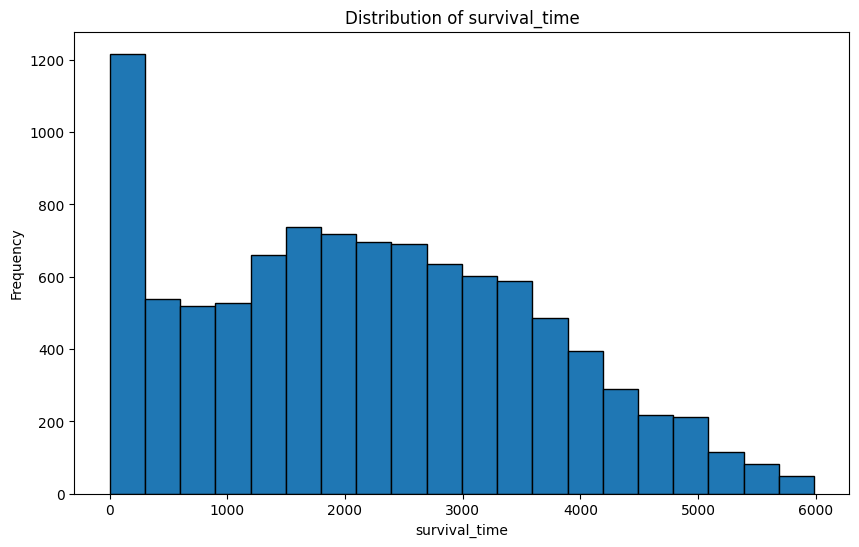

In [ ]:
# visualize `survival_time` distribution

plt.figure(figsize=(10, 6))
plt.hist(new_data['survival_time'], bins=20, edgecolor='black')
plt.xlabel('survival_time')
plt.ylabel('Frequency')
plt.title('Distribution of survival_time')
plt.show()

In [ ]:
# Create a list of unique languages
languages = new_data['language'].unique()

# Initialize the plotly figure
fig = go.Figure()

# Add traces for each language (but initially make them invisible)
for language in languages:
    language_data = new_data[new_data['language'] == language]
    fig.add_trace(go.Histogram(x=language_data['survival_time'], name=language, visible=False))

# Make the first language trace visible
fig.data[0].visible = True

# Create dropdown buttons
buttons = []
for i, language in enumerate(languages):
    buttons.append(dict(label=language,
                        method='update',
                        args=[{'visible': [j == i for j in range(len(languages))]},
                              {'title': f'Survival Time Distribution for {language}'}]))

# Add dropdown menu to the plot
fig.update_layout(
    updatemenus=[dict(active=0, buttons=buttons, x=1.15, y=1.15)],
    title_text='Survival Time Distribution for Different Programming Languages',
    xaxis_title='Survival Time (days)',
    yaxis_title='Count',
    barmode='overlay'
)

# Show the plot
pio.show(fig)

### Why Do We Need the `event` Column?

In the context of our analysis, the `event` column indicates whether a repository has become inactive. We define a repository as inactive if it has not been pushed to (updated) for over a year (365 days). This helps us identify repositories that are no longer actively maintained.

- `event = 1`: The repository has been inactive for over a year.
- `event = 0`: The repository is still active or has been inactive for less than a year.

#### Importance in Kaplan-Meier Estimation

1. **Censoring Information**:
    - The Kaplan-Meier estimator accounts for censored data, which refers to subjects whose event status is unknown or have not experienced the event by the end of the observation period.
    - By defining the `event` column, we provide crucial information on whether each repository's activity period has ended (event occurred) or is still ongoing (censored).

2. **Accurate Survival Function**:
    - The survival function estimates the probability that a subject (repository) will survive past a certain time.
    - Without the `event` column, we cannot distinguish between active and inactive repositories, leading to inaccurate survival function estimates.

3. **Analysis and Comparison**:
    - The `event` column allows us to perform meaningful comparisons between the survival times of repositories using different programming languages.
    - It helps in understanding the longevity and activity trends for each language, providing insights into their usage and popularity within the software community.

> By incorporating the `event` column, we ensure that our Kaplan-Meier analysis accurately reflects the activity status of repositories, leading to more reliable and insightful results.







In [ ]:
# Add the 'event' column based on the condition using .loc to avoid the SettingWithCopyWarning
new_data.loc[:, 'event'] = new_data['time_since_last_push'].apply(lambda x: 1 if x > 365 else 0)

# Display the first few rows of the modified DataFrame
new_data.head()

<ipython-input-42-7a92f9fc922d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,name,full_name,description,search_key,language,key_words,stars,forks,watchers,open_issues,created_at,updated_at,pushed_at,releases,survival_time,time_since_last_push,event
0,system-design-primer,donnemartin/system-design-primer,Learn how to design large-scale systems. Prep ...,Python,Python,"['design', 'design-patterns', 'design-system',...",264072,44767,264072,435,2017-02-26 16:15:28+00:00,2024-07-12 16:47:58+00:00,2024-06-29 00:09:30+00:00,0,2679,16,0
1,awesome-python,vinta/awesome-python,An opinionated list of awesome Python framewor...,Python,Python,"['awesome', 'collections', 'python', 'python-f...",212323,24654,212323,416,2014-06-27 21:00:06+00:00,2024-07-12 16:45:14+00:00,2024-07-08 23:26:43+00:00,0,3664,6,0
2,tensorflow,tensorflow/tensorflow,An Open Source Machine Learning Framework for ...,Python,C++,"['deep-learning', 'deep-neural-networks', 'dis...",184034,74063,184034,3727,2015-11-07 01:19:20+00:00,2024-07-12 16:44:43+00:00,2024-07-12 16:47:04+00:00,30,3170,3,0
3,Python,TheAlgorithms/Python,All Algorithms implemented in Python,Python,Python,"['algorithm', 'algorithm-competitions', 'algor...",182120,44004,182120,229,2016-07-16 09:44:01+00:00,2024-07-12 16:26:11+00:00,2024-07-12 16:25:12+00:00,0,2918,3,0
4,project-based-learning,practical-tutorials/project-based-learning,Curated list of project-based tutorials,Python,Python,"['beginner-project', 'cpp', 'golang', 'javascr...",181910,23897,181910,148,2017-04-12 05:07:46+00:00,2024-07-12 16:38:09+00:00,2024-07-10 18:02:06+00:00,0,2646,5,0


In [ ]:
print(new_data['event'].value_counts())

event
0    6258
1    3720
Name: count, dtype: int64


In [ ]:
# Count the number of active (event == 0) and inactive (event == 1) repositories per language
language_status = new_data.groupby(['language', 'event']).size().unstack(fill_value=0)

# Prepare data for plotting
active_counts = language_status[0]  # Active repositories
inactive_counts = language_status[1]  # Inactive repositories

# Create a bar plot for active vs inactive repositories
fig = go.Figure()

# Add bar traces
fig.add_trace(go.Bar(
    x=active_counts.index,
    y=active_counts.values,
    name='Active Repositories',
    marker_color='green'
))

fig.add_trace(go.Bar(
    x=inactive_counts.index,
    y=inactive_counts.values,
    name='Inactive Repositories',
    marker_color='red'
))

# Update layout for the bar chart
fig.update_layout(
    title='Comparison of Active and Inactive Repositories by Language',
    xaxis_title='Programming Language',
    yaxis_title='Number of Repositories',
    barmode='stack',
    legend_title='Repository Status',
    xaxis_tickangle=-45,
    height=600
)

# Show the bar plot
pio.show(fig)

# Optional: Create a pie chart for overall active vs inactive status
total_counts = new_data['event'].value_counts()

fig_pie = go.Figure(data=[go.Pie(
    labels=['Active', 'Inactive'],
    values=total_counts,
    hole=0.4,
    marker=dict(colors=['green', 'red'])
)])

# Update layout for the pie chart
fig_pie.update_layout(
    title='Overall Active vs Inactive Repositories',
)

# Show the pie chart
pio.show(fig_pie)


In [ ]:
def plot_lifelines_with_buttons(data, languages_per_page=15):
    """Plot survival lifelines with buttons to navigate through languages.

    data: DataFrame with columns ['survival_time', 'event', 'language']
    """
    # Group data by language
    grouped = data.groupby('language')
    languages = list(grouped.groups.keys())
    total_languages = len(languages)
    num_pages = (total_languages + languages_per_page - 1) // languages_per_page

    # Create figure
    fig = go.Figure()

    # Add traces for each language for the first page
    for page in range(num_pages):
        start = page * languages_per_page
        end = start + languages_per_page
        current_languages = languages[start:end]

        for language in current_languages:
            group = grouped.get_group(language)
            for index, row in group.iterrows():
                survival_time = row['survival_time']
                event = row['event']

                # Determine y-position
                y = languages.index(language)  # Use the index of the language

                if event == 0:
                    # Ongoing
                    fig.add_trace(go.Scatter(
                        x=[0, survival_time],
                        y=[y, y],
                        mode='lines',
                        line=dict(color='green'),
                        name=f'{language} - Active',
                        visible='legendonly'  # Initially hidden
                    ))
                else:
                    # Inactive
                    fig.add_trace(go.Scatter(
                        x=[0, survival_time],
                        y=[y, y],
                        mode='lines+markers',
                        line=dict(color='red'),
                        marker=dict(size=8),
                        name=f'{language} - Inactive',
                        visible='legendonly'  # Initially hidden
                    ))

        # Set traces for the current page to visible
        for i in range(start, end):
            if i < total_languages:
                fig.data[i].visible = True

    # Update layout for the figure
    fig.update_layout(
        title='Survival Lifelines of Repositories by Language and Event Status',
        xaxis_title='Survival Time (days)',
        yaxis_title='Programming Language',
        yaxis=dict(tickvals=list(range(total_languages)), ticktext=languages),
        updatemenus=[
            {
                'buttons': [
                    {
                        'label': f'Page {page + 1}',
                        'method': 'update',
                        'args': [
                            {'visible': [j // languages_per_page == page for j in range(len(fig.data))]},
                            {'title': f'Survival Lifelines - Page {page + 1}'}
                        ]
                    } for page in range(num_pages)
                ],
                'direction': 'down',
                'showactive': True,
                'x': 0.15,
                'xanchor': 'left',
                'y': 1.15,
                'yanchor': 'top'
            }
        ]
    )

    # Show the plot
    fig.show()

plot_lifelines_with_buttons(new_data)

In [ ]:
# Save DataFrame to CSV
"""
Saving the processed DataFrame (`new_data`) to a CSV file.
"""

# Define the output path
output_path = os.getenv('OUTPUT_PATH', '/content/processed_languages_frameworks.csv')

# Save the DataFrame to a CSV file
new_data.to_csv(output_path, index=False)

print(f"Processed data saved to {output_path}")

Processed data saved to /content/processed_languages_frameworks.csv
